In [3]:
%%time

from utils.utils import create_dataset, Trainer
from layer.layer import Embedding, FeaturesEmbedding, EmbeddingsInteraction, MultiLayerPerceptron

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Training on [{}].'.format(device))


Training on [cuda:0].
CPU times: user 761 ms, sys: 351 ms, total: 1.11 s
Wall time: 2.57 s


In [4]:
%%time

dataset = create_dataset('criteo', sample_num=100000, device=device)
field_dims, (train_X, train_y), (valid_X, valid_y), (test_X, test_y) = dataset.train_valid_test_split()


CPU times: user 7.03 s, sys: 1.25 s, total: 8.29 s
Wall time: 11 s


In [5]:
class FieldAwareFactorizationMachine(nn.Module):
    
    def __init__(self, field_dims, embed_dim=4):
        super(FieldAwareFactorizationMachine, self).__init__()
        
        self.field_dims = field_dims
        
        self.bias = nn.Parameter(torch.zeros((1, )))
        
        self.embed_linear = FeaturesEmbedding(field_dims, 1)
        self.embed_cross = nn.ModuleList([FeaturesEmbedding(field_dims, embed_dim) for _ in field_dims])

    def forward(self, x):
        # x shape: (batch_size, num_fields)
        # embed(x) shape: (batch_size, num_fields, embed_dim)
        
        num_fields = len(self.field_dims)

        embeddings = [embed(x) for embed in self.embed_cross]
        embeddings = torch.hstack(embeddings)

        i1, i2 = [], []
        for i in range(num_fields):
            for j in range(i+1, num_fields):
                i1.append(j * num_fields + i)
                i2.append(i * num_fields + j) 

        embedding_cross = torch.mul(embeddings[:,i1], embeddings[:,i2]).sum(dim=2).sum(dim=1, keepdim=True)

        output = self.embed_linear(x).sum(dim=1) + self.bias + embedding_cross
        output = torch.sigmoid(output)
        return output


 20%|██        | 122/600 [02:46<10:52,  1.36s/it]


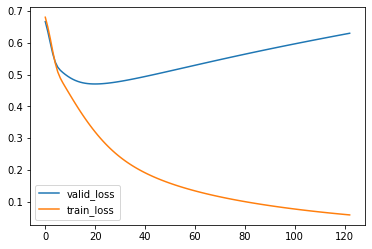

train_loss: 0.29481 | train_metric: 0.93917
valid_loss: 0.47093 | valid_metric: 0.74549
test_loss:  0.45304 | test_auc:  0.75700
CPU times: user 2min 47s, sys: 675 ms, total: 2min 47s
Wall time: 2min 48s


In [6]:
%%time

EMBEDDING_DIM = 8
LEARNING_RATE = 1e-4
REGULARIZATION = 1e-6
BATCH_SIZE = 4096
EPOCH = 600
TRIAL = 100

ffm = FieldAwareFactorizationMachine(field_dims, EMBEDDING_DIM).to(device)
optimizer = optim.Adam(ffm.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
criterion = nn.BCELoss()

trainer = Trainer(ffm, optimizer, criterion, BATCH_SIZE)
trainer.train(train_X, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
test_loss, test_auc = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_auc:  {:.5f}'.format(test_loss, test_auc))
